# EECE / CS 7268: Verifiable Machine Learning -- Fall 2025
# HW#3: Reachability Analysis of Neural Feedback Loops

**Submission Instructions:** Please upload a .ipynb file (including your code, plots, and written answers) to Gradescope. This file can be updated unlimited times until the submission deadline.

The goal of this assignment is to give you hands-on experience with reachability analysis of neural feedback loops. You will code some forward and backward reachability algorithms, leveraging existing NN verification libraries. Depending on your interests, you are encouraged to try implementing some sort of extension for the extra credit problem.

You're welcome to use Jax, PyTorch, TensorFlow, Keras, or other appropriate libraries to help make your life easier throughout the problems - we provide examples based on `jax_verify` but tried to make the function signatures somewhat framework-agnostic.

Please enter your contributions here! Mention if you have collaborated with someone on this homework or if you have used any AI tools for help with this homework! If this is not filled out, the assignment will be given a zero.

$\Rightarrow$ I use chatgpt, claude, and gemini for help.

# Dependencies, Imports, & Useful Functions

In [1]:
!apt install libgmp-dev libcdd-dev
!pip install torch \
  torchvision \
  packaging>=20.0 \
  pytest==8.1.1 \
  pylint>=2.15 \
  pytest-order>=1.0.0 \
  pytest-mock>=3.14 \
  appdirs>=1.4 \
  pyyaml>=5.0 \
  tqdm>=4.64 \
  graphviz>=0.20.3 \
  matplotlib \
  pandas \
  tabulate \
  colour \
  jax==0.5.3 \
  parameterized \
  pypoman \
  alphashape \
  scikit-learn \
  scipy \
  imageio \
  tqdm \
  pyclipper \
  pygifsicle \
  mypy \
  pylint
!pip install --no-deps "auto-lirpa @ git+https://gitlab.com/neu-autonomy/certifiable-learning/auto-lirpa@numpy2.0-update-hacks"
!pip install \
    "jax_verify @ git+https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify@mainline_repo"
!pip install --no-deps "crown_ibp @ git+https://gitlab.com/neu-autonomy/certifiable-learning/crown_ibp.git"
!pip install --no-deps "nfl_veripy @ git+https://github.com/neu-autonomy/nfl_veripy.git"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libcdd0d libgmpxx4ldbl
Suggested packages:
  libcdd-doc gmp-doc libgmp10-doc libmpfr-dev
The following NEW packages will be installed:
  libcdd-dev libcdd0d libgmp-dev libgmpxx4ldbl
0 upgraded, 4 newly installed, 0 to remove and 41 not upgraded.
Need to get 477 kB of archives.
After this operation, 2,215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgmpxx4ldbl amd64 2:6.2.1+dfsg-3ubuntu1 [9,580 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgmp-dev amd64 2:6.2.1+dfsg-3ubuntu1 [337 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcdd0d amd64 094m-1 [118 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcdd-dev amd64 094m-1 [12.9 kB]
Fetched 477 kB in 1s (400 kB/s)
Selecting previously unselected package libgmpxx4ldbl:amd64.
(Reading d

In [2]:
import argparse  # noqa: E402
import ast  # noqa: E402
import logging  # noqa: E402
import os  # noqa: E402
import time  # noqa: E402
from typing import Dict, Tuple  # noqa: E402

import numpy as np  # noqa: E402
import yaml  # noqa: E402

import nfl_veripy.analyzers as analyzers  # noqa: E402
import nfl_veripy.constraints as constraints  # noqa: E402
import nfl_veripy.dynamics as dynamics  # noqa: E402
from nfl_veripy.utils.nn import load_controller  # noqa: E402
from nfl_veripy.utils.utils import get_plot_filename  # noqa: E402

import torch
import numpy as np
import cvxpy as cp
from enum import Enum
import matplotlib.pyplot as plt
import jax_verify
import functools
import jax.numpy as jnp
from typing import Callable, Optional
from matplotlib.patches import Rectangle
from itertools import product

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.5.3, so it will not be used.
  warnings.warn(
W1101 13:08:50.619000 594 torch/utils/cpp_extension.py:118] No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(t

Some possibly useful methods for defining a NN in jax, copied in from the last HW assignment:

In [3]:
def pytorch_model_to_jax(torch_model: torch.nn.Sequential):
  params = []
  act = None

  # Extract params (weights, biases) from torch layers, to be used in
  # jax.
  # Note: This propagator assumes a feed-forward relu NN.
  for m in torch_model.modules():
    if isinstance(m, torch.nn.Sequential):
      continue
    elif isinstance(m, torch.nn.ReLU):
      if act is None or act == "relu":
        act = "relu"
    elif isinstance(m, torch.nn.Linear):
      w = m.weight.data.numpy().T
      b = m.bias.data.numpy()
      params.append((w, b))
      print(f'w',w)
      print(w.dtype)
  return functools.partial(relu_nn, params)

def relu_nn(params, inputs):
  for W, b in params[:-1]:
    outputs = jnp.dot(inputs, W) + b
    inputs = jnp.maximum(outputs, 0)
  W, b = params[-1]
  return jnp.dot(inputs, W) + b

def jax_interval_to_np_range(interval: jax_verify.IntervalBound) -> np.ndarray:
  return np.vstack([interval.lower, interval.upper]).T

def np_range_to_jax_interval(input_range: np.ndarray) -> jax_verify.IntervalBound:
  return jax_verify.IntervalBound(input_range[:, 0], input_range[:, 1])

Here are some methods as examples of working with the controller and dynamics:

In [4]:
# Load a dynamics model that implements x_{t+1} = Ax_{t} + Bu_{t} for a ground robot
dyn = dynamics.get_dynamics_instance("GroundRobot", "FullState")
# Load a controller for the ground robot that is trained to avoid an obstacle near the origin
controller = load_controller("GroundRobotSI", model_name="complex_potential_field")
jax_controller = pytorch_model_to_jax(controller)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


w [[-0.66153675 -0.8897745   0.2332237  -0.10649858  0.42408198 -0.14865513
   0.00706408 -0.23304147 -0.08028513 -0.02348628]
 [-0.23766133  0.21019074  0.0877184   0.28298175  0.26242232  0.0747429
  -0.5973526  -0.31963763 -0.13516468  0.68264914]]
float32
w [[  1.1408708    1.1195651   -0.06289028  -0.37404764   0.26601788
   -0.5510872   -0.28947356  -0.3508233   -0.0749135   -0.08350924]
 [ -0.6146511   -0.5767887    0.1443153    0.08732878  -0.2596323
   -2.0351346    0.08802073  -0.03470389  -0.08703898  -0.304279  ]
 [  0.43733922   0.8509252   -0.55184126  -0.22942397   0.6824455
   -0.29977256   0.20004778   1.0427448   -0.7966655    0.546436  ]
 [  0.85373807   0.72349274   0.22887641  -0.18512143   0.43135518
   -0.7139885    0.13797832   0.34031337  -0.3913044    2.8335488 ]
 [ -0.08356462  -0.39384836   0.31759378  -0.03011811   0.01620021
    0.08842723  -0.17867723  -0.5252315    0.17415997  -0.3877484 ]
 [ -1.188248    -1.3277417   -0.88288057   0.97945184   0.0754835

In [5]:
dyn

In [6]:
controller

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=2, bias=True)
)

In [7]:
jax_controller

functools.partial(<function relu_nn at 0x7a4861aeda80>, [(array([[-0.66153675, -0.8897745 ,  0.2332237 , -0.10649858,  0.42408198,
        -0.14865513,  0.00706408, -0.23304147, -0.08028513, -0.02348628],
       [-0.23766133,  0.21019074,  0.0877184 ,  0.28298175,  0.26242232,
         0.0747429 , -0.5973526 , -0.31963763, -0.13516468,  0.68264914]],
      dtype=float32), array([-0.19608404,  0.05535944,  0.19904482,  0.11123871, -0.60506296,
        0.3257196 ,  0.04503353, -0.1455753 ,  0.07562071,  0.11256334],
      dtype=float32)), (array([[  1.1408708 ,   1.1195651 ,  -0.06289028,  -0.37404764,
          0.26601788,  -0.5510872 ,  -0.28947356,  -0.3508233 ,
         -0.0749135 ,  -0.08350924],
       [ -0.6146511 ,  -0.5767887 ,   0.1443153 ,   0.08732878,
         -0.2596323 ,  -2.0351346 ,   0.08802073,  -0.03470389,
         -0.08703898,  -0.304279  ],
       [  0.43733922,   0.8509252 ,  -0.55184126,  -0.22942397,
          0.6824455 ,  -0.29977256,   0.20004778,   1.0427448 

# Problem 1: Forward Reachability Analysis

Here is an example of how to implement the closed-loop dynamics for 1 step (`step_1`) and plot some randomly sampled ($x_t, x_{t+1})$ pairs (`plot_1step_samples_and_bounds`):

In [69]:
def step_1(xt):
  ut = jax_controller(xt)
  xt1 = dyn.dynamics_step_jnp(xt, ut)
  return xt1

def plot_1step_samples_and_bounds(initial_state_range: np.ndarray, step_fn: Callable, bounds: Optional[np.ndarray]) -> None:

  xt = np.random.uniform(low=initial_state_range[:, 0], high=initial_state_range[:, 1], size=(1000,2))
  xt1 = step_fn(xt)
  print(f'xt',xt)
  print(f'xt1',xt1)
  plt.plot(xt[:, 0], xt[:, 1], 'o', markersize=1, c='green')
  plt.plot(xt1[:, 0], xt1[:, 1], 'o', markersize=1, c='gray')
  dims = [0, 1]
  if bounds is not None:
    rect = Rectangle(
        bounds[dims, 0],
        bounds[dims[0], 1] - bounds[dims[0], 0],
        bounds[dims[1], 1] - bounds[dims[1], 0],
        fc="None",
        linewidth=2,
        edgecolor="red",
    )
    plt.gca().add_patch(rect)
  plt.show()

xt [[-5.27102512  1.07859838]
 [-5.15828847  0.79997727]
 [-4.8671473   1.04550143]
 ...
 [-5.03264957  0.76319827]
 [-4.99402906  1.02436116]
 [-5.38036907  0.64366906]]
xt1 [[-4.6425323  1.5189345]
 [-4.54371    1.2354653]
 [-4.2555804  1.5118055]
 ...
 [-4.424239   1.2055752]
 [-4.378221   1.4810909]
 [-4.7624373  1.0570416]]


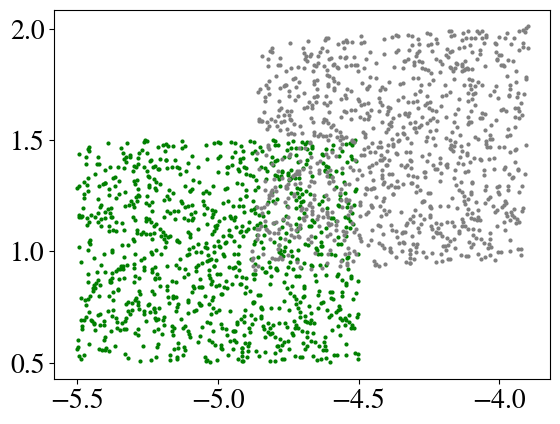

In [67]:
initial_state_range = np.array([[-5.5,-4.5],[0.5,1.5]])
plot_1step_samples_and_bounds(initial_state_range, step_1, bounds=None)

## 1a) Calculate outer bounds on the 1-step reachable set

You'll start by implementing a function that calculates outer bounds on the 1-step reachable set. It's up to you how you do this, but as an example, you could do this in 3 lines using `jax_verify`.

**Deliverables**:
- Implement `compute_1step_reachable_set`
- Plot your computed reachable set bounds over the Monte Carlo samples

initial_state_range.shape (2, 2)
initial_state_range [[-5.5 -4.5]
 [ 0.5  1.5]]
IBP_1-step Reachable Set: [[-9.408226  -0.4432249]
 [-1.0392534  5.7169943]].
CROWNIBP_1-step Reachable Set: [[-5.5034943  -3.792193  ]
 [ 0.64243686  3.123317  ]].
fwdCROWN_1-step Reachable Set: [[-4.8822904  -3.8872874 ]
 [ 0.89878964  2.0116715 ]].
xt [[-4.91095437  0.96247082]
 [-5.47390681  1.21780623]
 [-4.92241042  1.40916693]
 ...
 [-4.54863208  0.98977654]
 [-5.45604618  1.17246238]
 [-5.20400714  1.45864348]]
xt1 [[-4.3005066  1.4220686]
 [-4.8327303  1.650602 ]
 [-4.296276   1.8880446]
 ...
 [-3.9514241  1.47523  ]
 [-4.817115   1.6044363]
 [-4.565171   1.9206009]]


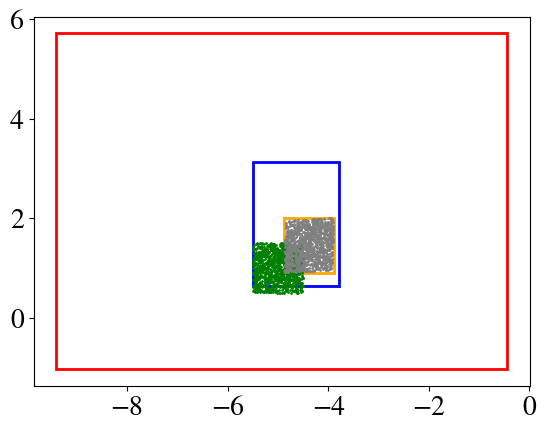

In [130]:
def compute_1step_reachable_set(initial_state_range: np.ndarray, step_fn: Callable, method:str='CRIBP') -> np.ndarray:

  # - initial_state_range: np.array of size (num_states, 2) containing min/max per state
  # - step_fn: function that takes 1 argument, x_t, and outputs the subsequent state, x_{t+1}
  #
  # Returns:
  # - next_state_range: np.array of same shape as initial_state_range, but corresponding to the next timestep

  # TODO: implement this
  OneStep_in_JAXbounds_xt = np_range_to_jax_interval(initial_state_range)

  #print(method)

  if method == 'CRIBP':
    OneStep_out_JAXbounds_xt1 = jax_verify.crownibp_bound_propagation(step_fn, OneStep_in_JAXbounds_xt)
    #print(method == 'CRIBP')
  elif method == 'IBP':
    OneStep_out_JAXbounds_xt1 = jax_verify.interval_bound_propagation(step_fn, OneStep_in_JAXbounds_xt)
    #print(method == 'IBP')
  elif method == 'fwdCR': # fwdCrown
    OneStep_out_JAXbounds_xt1 = jax_verify.forward_crown_bound_propagation(step_fn, OneStep_in_JAXbounds_xt)
    #print(method == 'fwdCR')


  OneStep_out_NPrange_xt1 = jax_interval_to_np_range(OneStep_out_JAXbounds_xt1)
  return OneStep_out_NPrange_xt1



print(f'initial_state_range.shape', initial_state_range.shape)
print(f'initial_state_range' ,initial_state_range)

IBP_output_range = compute_1step_reachable_set(initial_state_range, step_1, 'IBP')
print(f"IBP_1-step Reachable Set: {IBP_output_range}.")
CRIBP_bound = compute_1step_reachable_set(initial_state_range, step_1, 'CRIBP')
print(f"CROWNIBP_1-step Reachable Set: {CRIBP_bound}.")
fwdCR_bound = compute_1step_reachable_set(initial_state_range, step_1, 'fwdCR')
print(f"fwdCROWN_1-step Reachable Set: {fwdCR_bound}.")

_real_show = plt.show
plt.show = lambda *a, **k: None

# You can pass the computed output_range to the function we defined before
# and it will draw your bound as a rectangle over the sampled points:
plot_1step_samples_and_bounds(initial_state_range, step_1, bounds=IBP_output_range)

plt.show = _real_show

dims = [0, 1]
for b, color in zip([CRIBP_bound, fwdCR_bound], ['blue', 'orange']):
    rect = Rectangle(
        b[dims, 0],
        b[dims[0], 1] - b[dims[0], 0],
        b[dims[1], 1] - b[dims[1], 0],
        fc="None",
        linewidth=2,
        edgecolor=color,
    )
    plt.gca().add_patch(rect)

plt.show()


In [107]:
import jax_verify

# 列出目前 jax_verify 模組裡所有函式和屬性名稱
print("=== jax_verify version ===")
try:
    import importlib.metadata
    print(importlib.metadata.version("jax_verify"))
except Exception as e:
    print("無法讀取版本：", e)

print("\n=== ava attributes or functions ===")
for name in dir(jax_verify):
    if not name.startswith("_"):
        print(name)


=== jax_verify version ===
1.0

=== ava attributes or functions ===
IntersectionBoundTransform
IntervalBound
backward_crown_bound_propagation
backward_fastlin_bound_propagation
crownibp_bound_propagation
forward_crown_bound_propagation
forward_fastlin_bound_propagation
ibp_transform
ibpforwardfastlin_bound_propagation
interval_bound_propagation
nonconvex_constopt_bound_propagation
nonconvex_ibp_bound_propagation
open_file
src


## 1b) Calculate outer bounds on the reachable sets for T steps into the future: Iterative Version

Now that you have a 1-step reachable set algorithm, you will extend this to compute reachable sets T steps into the future.

**Deliverables**:
- Implement `compute_Tstep_reachable_set_iterative`, an iterative algorithm to get reachable set outer bounds for timesteps $(1, 2, ..., T)$.



To help out, we provide you with a function to plot those samples (and bounds, for later parts of the problem), so you can see what the forward reachable sets should roughly look like:

bounds is None


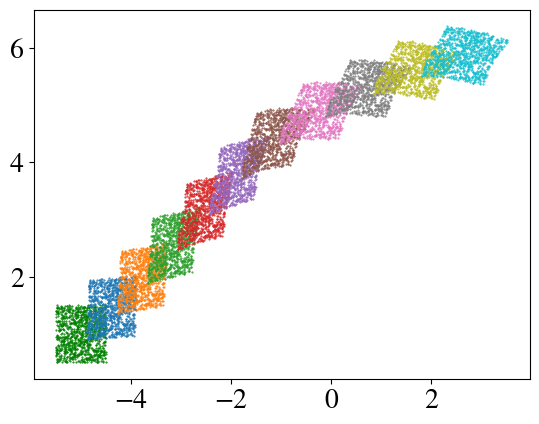

In [105]:
from IPython.display import display, clear_output
def plot_Tstep_samples_and_bounds(initial_state_range: np.ndarray, step_1: Callable, num_steps: int, bounds: Optional[np.ndarray]) -> None:
  plt.figure()
  # Sample a bunch of points in the initial state set, then run those forward T steps and plot
  xt = np.random.uniform(low=initial_state_range[:, 0], high=initial_state_range[:, 1], size=(1000,2))
  plt.plot(xt[:, 0], xt[:, 1], '.', markersize=1, c='green')
  for _ in range(num_steps):
    xt = step_1(xt)
    plt.plot(xt[:, 0], xt[:, 1], '.', markersize=1)

  # If passed in, draw the bounds as a rectangle at each timestep
  if bounds is not None:
    for bound in bounds:
      dims = [0, 1]
      rect = Rectangle(
          bound[dims, 0],
          bound[dims[0], 1] - bound[dims[0], 0],
          bound[dims[1], 1] - bound[dims[1], 0],
          fc="None",
          linewidth=1,
          edgecolor="red",
      )
      plt.gca().add_patch(rect)
  else:
    print('bounds is None')
  display(plt.gcf())
  plt.close(plt.gcf())

initial_state_range = np.array([[-5.5,-4.5],[.5,1.5]])
num_steps = 10
plot_Tstep_samples_and_bounds(initial_state_range, step_1, num_steps, bounds=None)

Now that you have visualized what the reachable sets should roughly look like, you will implement an algorithm to compute outer bounds on those reachable sets.

Your first implementation will compute reachable sets iteratively, as in:

- $\bar{R}_1(X_t) = \texttt{compute_1step_reachable_set}(X_t)$
- $\bar{R}_2(X_t) = \texttt{compute_1step_reachable_set}(\bar{R}_1(X_t))$
- $\ldots$

---CRIBP---


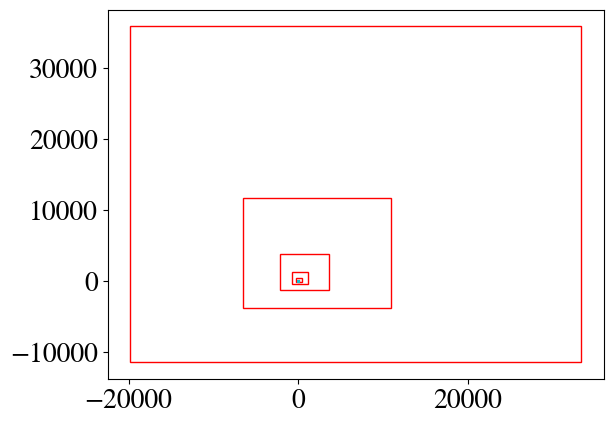

[[-5.5034943  -3.792193  ]
 [ 0.64243686  3.123317  ]]
[[-6.611719   -1.5425518 ]
 [ 0.39051956  6.833563  ]]
[[-11.433159    5.526435 ]
 [ -1.1331232  16.468798 ]]
[[-29.603966  35.05206 ]
 [-11.361298  44.746532]]
[[-83.45118 127.93802]
 [-41.79267 133.49828]]
[[-244.16241  393.7066 ]
 [-133.66934  398.65356]]
[[-723.64716 1190.3729 ]
 [-407.84027 1251.6594 ]]
[[-2170.4387  3613.6787]
 [-1239.0027  3858.4348]]
[[-6548.25   10977.738 ]
 [-3760.9111 11796.717 ]]
[[-19814.512  33343.414]
 [-11414.762  35929.203]]
---IBP---


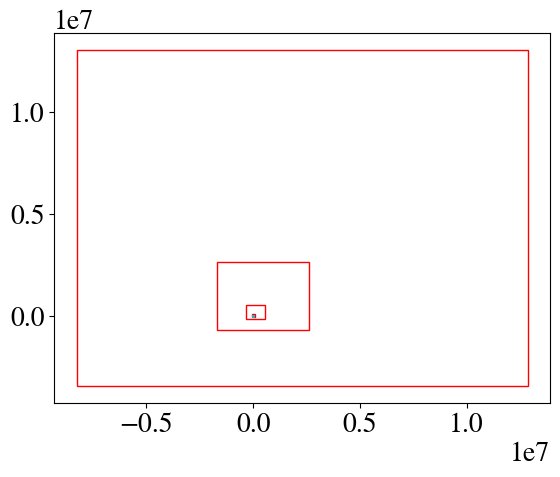

[[-9.408226  -0.4432249]
 [-1.0392534  5.7169943]]
[[-29.34911   28.865639]
 [ -9.787537  35.40084 ]]
[[-125.606674  178.07251 ]
 [ -50.36638   184.5799  ]]
[[-594.7925   908.63635]
 [-246.29521  922.65594]]
[[-2895.1455  4492.655 ]
 [-1203.6384  4555.059 ]]
[[-14189.323   22089.555 ]
 [ -5898.6597  22406.195 ]]
[[-69659.31  108511.81 ]
 [-28949.504 110100.484]]
[[-342114.03  532989.1 ]
 [-142157.28  540857.75]]
[[-1680366.1  2617937.2]
 [ -698197.5  2656695.2]]
[[-8253661.  12858868. ]
 [-3429358.8 13049408. ]]
---fwd---


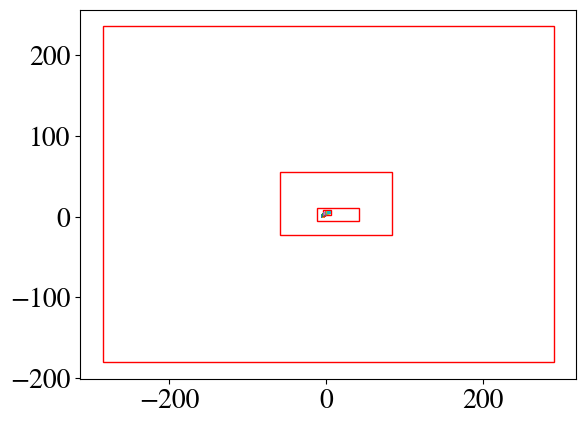

[[-4.8822904  -3.8872874 ]
 [ 0.89878964  2.0116715 ]]
[[-4.275136  -3.281084 ]
 [ 1.3574772  2.5879693]]
[[-3.7608454 -2.4079084]
 [ 1.8756806  3.4280386]]
[[-3.3848126 -1.6667686]
 [ 2.1791286  4.117058 ]]
[[-2.807778  -0.6691826]
 [ 2.6465688  4.883765 ]]
[[-2.6466608  1.7748066]
 [ 2.7305155  6.161356 ]]
[[-4.328923   6.754871 ]
 [ 2.1600845  7.652641 ]]
[[-11.035512   42.22773  ]
 [ -5.2920313  11.237516 ]]
[[-58.368988  83.284676]
 [-22.75731   55.139526]]
[[-284.72897  289.73932]
 [-180.39723  235.64923]]


In [131]:
def print_output_ranges(range_Array:np.ndarray):
  for i in range_Array:
    print(i)

def compute_Tstep_reachable_set_iterative(initial_state_range: np.ndarray, step_fn: Callable, num_steps: int, method='CRIBP') -> np.ndarray:
  #
  # initial_state_range: (num_states, 2) array containing min/max per state
  # step_fn: function that accepts array of state samples at initial timestep and returns list of state samples at times [t+1, ..., t+num_steps]
  # num_steps: non-negative integer
  #
  # Return:
  # - list of state_ranges at times [t+1, t+2, ..., t+num_steps]
  #  i.e., [(num_states, 2)_t=t+1, ..., (num_states, 2)_t=t+T]

  Tstep_out_array = []
  bound = initial_state_range
  if method == 'CRIBP':
    for i in range(num_steps):
      bound = compute_1step_reachable_set(bound, step_fn, 'CRIBP')
      Tstep_out_array.append(bound)
      #print(f"CROWNIBP_1-step Reachable Set: {bound}.")
  elif method == 'IBP':
    for i in range(num_steps):
      bound = compute_1step_reachable_set(bound, step_fn, 'IBP')
      Tstep_out_array.append(bound)
      #print(f"IBP_1-step Reachable Set: {bound}.")
  else: # fwdCrown
    for i in range(num_steps):
      bound = compute_1step_reachable_set(bound, step_fn, 'fwdCR')
      Tstep_out_array.append(bound)
      #print(f"fwdCR_1-step Reachable Set: {bound}.")

  return Tstep_out_array

initial_state_range = np.array([[-5.5,-4.5],[.5,1.5]])
print('---CRIBP---', flush=True)
CRIBP_Tstep_output_ranges = compute_Tstep_reachable_set_iterative(initial_state_range, step_1, num_steps, 'CRIBP')
plot_Tstep_samples_and_bounds(initial_state_range, step_1, num_steps, bounds=CRIBP_Tstep_output_ranges)
print_output_ranges(CRIBP_Tstep_output_ranges)

print('---IBP---')
IBP_Tstep_output_ranges = compute_Tstep_reachable_set_iterative(initial_state_range, step_1, num_steps, 'IBP')
plot_Tstep_samples_and_bounds(initial_state_range, step_1, num_steps, bounds=IBP_Tstep_output_ranges)
print_output_ranges(IBP_Tstep_output_ranges)


print('---fwdCR---')
fwdCR_Tstep_output_ranges = compute_Tstep_reachable_set_iterative(initial_state_range, step_1, num_steps, 'fwdCR')
plot_Tstep_samples_and_bounds(initial_state_range, step_1, num_steps, bounds=fwdCR_Tstep_output_ranges)
print_output_ranges(fwdCR_Tstep_output_ranges)


## 1c) Calculate outer bounds on the reachable sets for T steps into the future: One-Shot Version

Iterative reachability analysis can provide excessively conservative bounds, for several reasons. To address this, you will implement one way to get tighter bounds, by instead computing the bounds for all timesteps in one-shot, i.e.,

- $\bar{R}_T(X_t), \ldots, \bar{R}_2(X_t), \bar{R}_1(X_t) = \texttt{compute_Tstep_reachable_set}(X_t, T)$

Remember, if the function you ask `jax_verify` to compute bounds on returns a list of outputs, you will get a list of bounds that corresponds to each output in the list. We've helped you out by implementing `step_T`, which outputs a list of future states for a given initial state. Since `jax_verify` expects the function to verify just has 1 argument (e.g., the initial state), it's helpful to use `functools.partial` to set any other arguments to a particular value (e.g., `num_steps`).

**Deliverables**:
- Implement `compute_Tstep_reachable_set_one_shot`
- Briefly comment on the difference between the two algorithms' bounds and runtimes

In [132]:
def step_T(num_steps: int, xt: np.ndarray) -> list[np.ndarray]:
  #
  # num_steps: non-negative integer
  # xt: (num_samples, num_states) np array of state samples at time t
  #
  # Return:
  # - list of state samples at times [t+1, t+2, ..., t+num_steps]
  #  i.e., [(num_samples, num_states)_t=t+1, ..., (num_samples, num_states)_t=t+num_steps]
  #
  # jax_verify will by default compute bounds on any "outputs" of the function
  # to verify, so if you return a list of states at each timestep, you'll
  # get bounds on all reachable sets in one call.

  xts = [xt]
  for _ in range(num_steps):
    ut = jax_controller(xts[-1])
    xts.append(dyn.dynamics_step_jnp(xts[-1], ut))
  return xts[1:]

In [133]:
num_steps = 10
step_Fn = functools.partial(step_T, num_steps)

step_Fn(np.array([[-5., 0.]]))

[Array([[-4.4174013,  0.3473388]], dtype=float32),
 Array([[-3.847242 ,  0.8128644]], dtype=float32),
 Array([[-3.283502 ,  1.3380518]], dtype=float32),
 Array([[-2.723895 ,  1.9251441]], dtype=float32),
 Array([[-2.1296759,  2.5561213]], dtype=float32),
 Array([[-1.5110402,  3.2019758]], dtype=float32),
 Array([[-0.77865297,  3.8047707 ]], dtype=float32),
 Array([[0.16298616, 4.276965  ]], dtype=float32),
 Array([[1.120466 , 4.6570745]], dtype=float32),
 Array([[2.0942676, 4.9557834]], dtype=float32)]

CRIBP_bound [array([[-5.5034943 , -3.792193  ],
       [ 0.64243686,  3.123317  ]], dtype=float32), array([[-12.025629 ,   8.994119 ],
       [ -3.9995959,  18.789562 ]], dtype=float32), array([[-54.28426 ,  80.9266  ],
       [-29.142797, 103.31907 ]], dtype=float32), array([[-255.03639,  422.36313],
       [-149.26616,  518.02905]], dtype=float32), array([[-1228.8568,  2085.155 ],
       [ -733.4386,  2557.4417]], dtype=float32), array([[-5993.171 , 10234.535 ],
       [-3594.5806, 12574.336 ]], dtype=float32), array([[-29366.49 ,  50238.7  ],
       [-17635.623,  61775.52 ]], dtype=float32), array([[-144131.52,  246701.28],
       [ -86584.46,  303445.4 ]], dtype=float32), array([[-707781.3, 1211655.2],
       [-425223.7, 1490493.1]], dtype=float32), array([[-3476263.5,  5951323. ],
       [-2088531.1,  7321100.5]], dtype=float32)]


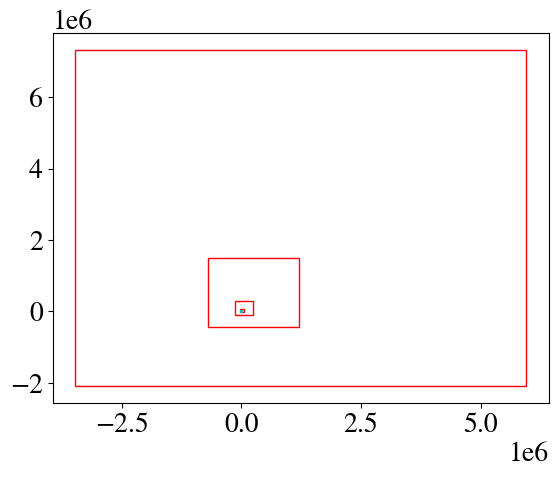

IBP_bound [array([[-9.408226 , -0.4432249],
       [-1.0392534,  5.7169943]], dtype=float32), array([[-29.34911 ,  28.865639],
       [ -9.787537,  35.40084 ]], dtype=float32), array([[-125.606674,  178.07251 ],
       [ -50.36638 ,  184.5799  ]], dtype=float32), array([[-594.7925 ,  908.63635],
       [-246.29521,  922.65594]], dtype=float32), array([[-2895.1455,  4492.655 ],
       [-1203.6384,  4555.059 ]], dtype=float32), array([[-14189.323 ,  22089.555 ],
       [ -5898.6597,  22406.195 ]], dtype=float32), array([[-69659.31 , 108511.81 ],
       [-28949.504, 110100.484]], dtype=float32), array([[-342114.03,  532989.1 ],
       [-142157.28,  540857.75]], dtype=float32), array([[-1680366.1,  2617937.2],
       [ -698197.5,  2656695.2]], dtype=float32), array([[-8253661. , 12858868. ],
       [-3429358.8, 13049408. ]], dtype=float32)]


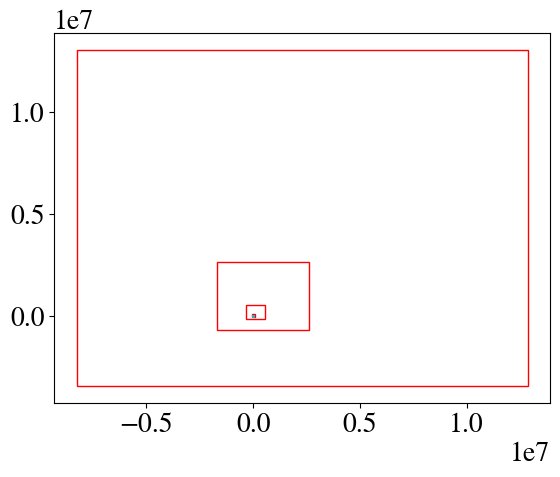

fwdCR_bound [array([[-4.8822904 , -3.8872874 ],
       [ 0.89878964,  2.0116715 ]], dtype=float32), array([[-4.27514  , -3.2810817],
       [ 1.3574743,  2.5879707]], dtype=float32), array([[-3.6908116, -2.4078825],
       [ 1.8780181,  3.4280515]], dtype=float32), array([[-4.129116  , -0.02119255],
       [ 2.2192955 ,  5.241912  ]], dtype=float32), array([[-16.850742 ,  14.097487 ],
       [ -1.3467822,  17.31163  ]], dtype=float32), array([[-113.9671 ,  214.60013],
       [ -43.11349,  132.78505]], dtype=float32), array([[-861.90137, 1289.815  ],
       [-306.27167, 1044.3591 ]], dtype=float32), array([[-6372.6895,  9081.681 ],
       [-2205.2297,  7701.749 ]], dtype=float32), array([[-47704.35 ,  69745.52 ],
       [-16371.303,  55175.94 ]], dtype=float32), array([[-345920.53,  491172.62],
       [-119289.91,  414297.9 ]], dtype=float32)]


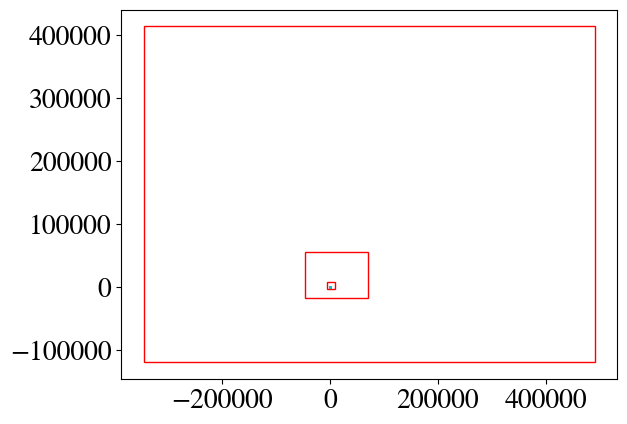

In [137]:
def compute_Tstep_reachable_set_one_shot(initial_state_range: np.ndarray, step_fn: Callable, num_steps: int, method='CRIBP') -> np.ndarray:
  #
  # initial_state_range: (num_states, 2) array containing min/max per state
  # step_fn: function that accepts array of state samples at initial timestep and returns list of state samples at times [t+1, ..., t+num_steps]
  # num_steps: non-negative integer
  #
  # Return:
  # - list of state_ranges at times [t+1, t+2, ..., t+num_steps]
  #  i.e., [(num_states, 2)_t=t+1, ..., (num_states, 2)_t=t+T]

  # TODO: implement this using

  Tstep_in_JAXbounds_xt = np_range_to_jax_interval(initial_state_range)

  if method == 'CRIBP':
    Tstep_out_JAXbounds_xtT = jax_verify.crownibp_bound_propagation(step_fn, Tstep_in_JAXbounds_xt)
  elif method == 'IBP':
    Tstep_out_JAXbounds_xtT = jax_verify.interval_bound_propagation(step_fn, Tstep_in_JAXbounds_xt)
  elif method == 'fwdCR':
    Tstep_out_JAXbounds_xtT = jax_verify.forward_crown_bound_propagation(step_fn, Tstep_in_JAXbounds_xt)

  Tstep_out_NPrange_xtT = []
  for i in Tstep_out_JAXbounds_xtT:
    Tstep_out_NPrange_xtT.append(jax_interval_to_np_range(i))

  return Tstep_out_NPrange_xtT


num_steps = 10
step_Fn = functools.partial(step_T, num_steps)
step_Fn(np.array([[-5., 0.]]))


CRIBP_bound = compute_Tstep_reachable_set_one_shot(initial_state_range, step_Fn, num_steps, 'CRIBP')
print(f'CRIBP_bound',CRIBP_bound)
plot_Tstep_samples_and_bounds(initial_state_range, step_1, num_steps, bounds=CRIBP_bound)


IBP_bound = compute_Tstep_reachable_set_one_shot(initial_state_range, step_Fn, num_steps, 'IBP')
print(f'IBP_bound',IBP_bound)
plot_Tstep_samples_and_bounds(initial_state_range, step_1, num_steps, bounds=IBP_bound)


fwdCR_bound = compute_Tstep_reachable_set_one_shot(initial_state_range, step_Fn, num_steps, 'fwdCR')
print(f'fwdCR_bound',fwdCR_bound)
plot_Tstep_samples_and_bounds(initial_state_range, step_1, num_steps, bounds=fwdCR_bound)



How do your iterative and one-shot reachable sets compare? The one-shot sets should be tighter, which may become more noticeable after a few timesteps. How did the computation time compare?

## 1d) Try your one-shot forward reachability algorithm on bifurcating dynamics

So far, we considered an initial state set that had positive y component, so the robot went "up" around the obstacle, regardless of where it started within that set. Now, let's see how things look if we move the `initial_state_set` to span y=0.

**Deliverables**:
- Plot of the samples over 10 timesteps (should just be able to run the 1st cell below)
- Plot of the reachable set estimates over 2 timesteps (should just be able to run the 2nd cell below)


Visualize 10 steps of the dynamics via sampling:

In [ ]:
initial_state_range = np.array([[-5.5,-4.5],[-.5,.5]])
plot_Tstep_samples_and_bounds(initial_state_range, step_1, num_steps, bounds=None)

Next, run your one-shot forward reachability algorithm -- just for 1 or 2 timesteps -- to see how well it bounds the "true" reachable set (as estimated by the samples):

In [ ]:
num_steps = 2
step_fn = functools.partial(step_T, num_steps)
output_ranges = compute_Tstep_reachable_set_one_shot(initial_state_range, step_fn, num_steps)
plot_Tstep_samples_and_bounds(initial_state_range, step_1, num_steps, bounds=output_ranges)

The bounds will probably be quite loose. We will use backward reachability in the next problem to try to get a more useful answer.

# Problem 2: Backward Reachability Analysis

Sometimes, the forward reachable set over-approximations are way too loose to be useful, so we need a new strategy. Or other times, it may not even be important to explicitly compute the forward reachable sets. For example, if we simply want to verify that the system will not enter some part of the state space (e.g., for obstacle avoidance), we could try to directly verify that property instead.

In this problem, instead of computing forward reachable sets starting from the `initial_state_set`, we will solve the backward reachability problem. First, we will define a `target_state_set`, which describes the states we do not want our system to ever enter.

Then, we will define the `backprojection_sets` as all the states that would lead to the `target_state_set`, when following the system's dynamics and trained control policy. Since it will be intractable to compute the `backprojection_sets` exactly, we will aim to compute outer bounds on these sets.

How is this useful? Once we have these `backprojection_sets` computed, right before we let our robot start driving, we can check that it is not starting in one of the `backprojection_set` over-approximations, and if it isn't, we have a proof that the system will not enter the `target_state_set`. For an even stronger result, if you can prove that the first backprojection set is inside the target set, it follows that as long as the system starts outside of the target set, the system will never enter the target set.

## 2a) Compute "true" backprojection sets by sampling

We are trying to compute the backprojection set but it's difficult to know what this "should" look like. To get an idea (and an under-approximation), sample a bunch of points from the state space and check if the subsequent state (i.e., after running that state through the closed-loop dynamics for 1) will be inside the target set. As a hint, all of these points should be inside the target set, since this is a well-trained collision avoidance policy.

**Deliverables**:
- Implement `estimate_true_backprojection_set`
- Plot the "true" (sampling-based) backprojection set and the target set

In [ ]:
target_state_set = np.array([[-1.0, 1.0], [-1.0, 1.0]])*0.2

def get_true_backprojection_set(target_state_set: np.ndarray, step_fn: Callable) -> np.ndarray:

  # Return:
  # - np.array of samples within $P_1(X_t)$ (e.g., if only 13 of your 10000 samples end up in the target set, you'd return an array of size (13,2))

  # TODO: Implement this

  return true_backprojection_set

true_backprojection_set = get_true_backprojection_set(target_state_set, step_1)

plt.plot(true_backprojection_set[:, 0], true_backprojection_set[:, 1], '.')
rect = Rectangle(
    target_state_set[[0, 1], 0],
    target_state_set[0, 1] - target_state_set[0, 0],
    target_state_set[1, 1] - target_state_set[1, 0],
    fc="None",
    linewidth=2,
    edgecolor="red",
)
plt.gca().add_patch(rect)
plt.show()

## 2b) Compute backreachable set using LPs

Recall that for some target set, $X_t$, the backreachable set, $R_1(X_t)$, is the set of states for which *some* control within the control limits would lead the system into the target set:

$R_1(X_t) = \{ x_{t-1} | Ax_{t-1} + Bu_{t-1} \in X_t, u_{t-1} \in U \}$

Here, you'll compute rectangular outer bounds on $R_1(X_t)$ by setting up some LPs, and you'll then use these bounds in subsequent problems.

**Deliverables**:
- Implement `get_backreachable_set`
- Plot the rectangular bounds on the backreachable set, along with the target set and the "true" backprojection set from before

In [ ]:
def get_backreachable_set(target_state_set: np.ndarray, dyn: dynamics.Dynamics) -> np.ndarray:

  # Hint: you may want to use dyn.At, dyn.bt, dyn.u_limits, or dyn.dynamics_step
  # Hint: you may want to use cvxpy for this

  # TODO: Implement this

  return backreachable_set

backreachable_set = get_backreachable_set(target_state_set, dyn)

plt.plot(true_backprojection_set[:, 0], true_backprojection_set[:, 1], '.')
rect = Rectangle(
    target_state_set[[0, 1], 0],
    target_state_set[0, 1] - target_state_set[0, 0],
    target_state_set[1, 1] - target_state_set[1, 0],
    fc="None",
    linewidth=2,
    edgecolor="red",
)
plt.gca().add_patch(rect)
rect = Rectangle(
    backreachable_set[[0, 1], 0],
    backreachable_set[0, 1] - backreachable_set[0, 0],
    backreachable_set[1, 1] - backreachable_set[1, 0],
    fc="None",
    linewidth=2,
    edgecolor="black",
)
plt.gca().add_patch(rect)
plt.show()

## 2c) Compute backprojection set using LPs

In class we derived 2 ways to refine the `backreachable_set` using CROWN. You are welcome to implement either version.

- Version 1: Relax `step_1` over $\bar{R}_1(X_t)$ to get $M, n$ such that $Mx_{t-1}+n \leq Cx_t$, to get the polytope description of $\bar{P}_1(X_t)$ without solving an LP (for this HW, you probably should inflate this to a rectangle to make plotting & partitioning easier)
- Version 2: Relax `jax_controller` over $\bar{R}_1(X_t)$ to get to get $\bar{M}, \bar{n}, \bar{M}', \bar{n}'$ such that $\bar{M}'x_{t-1}+\bar{n}' \leq \pi(x_t) \leq \bar{M}x_{t-1}+\bar{n}$, then add these inequalities as additional constraints to the LP you used to get $\bar{R}_1(X_t)$.

Hint: You may want to use `backward_crown_bound_propagation_linfun`, which is a small modification to `jax_verify` to output the slope/offset of the linear bounds rather than the min/max over the domain.

**Deliverables**:
- Implement `get_backprojection_set`
- Plot the BP, BR, and "true" BP sets together

In [ ]:
from nfl_veripy.utils.closed_loop_verification_jax import backward_crown_bound_propagation_linfun

# Hint: to get the linear CROWN bounds from jax_verify:
input_bounds = np_range_to_jax_interval(backreachable_set)
obj = jnp.vstack((jnp.eye(dyn.num_inputs), -jnp.eye(dyn.num_inputs)))
linfuns = backward_crown_bound_propagation_linfun(jax_controller, input_bounds, obj=obj)

# Then linfuns[0].lin_coeffs and linfuns[0].offset will contain the slope/offset from state to control
# Hint: You'll need to think about the signs of the entries in obj & linfuns to construct the inequalities properly

In [ ]:
def get_backprojection_set(target_state_set: np.ndarray, dyn: dynamics.Dynamics, backreachable_set: np.ndarray, controller: Callable) -> np.ndarray:

  # Hint: you may want to use dyn.At, dyn.bt, dyn.u_limits, or dyn.dynamics_step
  # Hint: you may want to use cvxpy for this

  # TODO: Implement this

  return backreachable_set

backprojection_set = get_backprojection_set(target_state_set, dyn, backreachable_set, jax_controller)

plt.plot(true_backprojection_set[:, 0], true_backprojection_set[:, 1], '.')
rect = Rectangle(
    target_state_set[[0, 1], 0],
    target_state_set[0, 1] - target_state_set[0, 0],
    target_state_set[1, 1] - target_state_set[1, 0],
    fc="None",
    linewidth=2,
    edgecolor="red",
)
plt.gca().add_patch(rect)
rect = Rectangle(
    backreachable_set[[0, 1], 0],
    backreachable_set[0, 1] - backreachable_set[0, 0],
    backreachable_set[1, 1] - backreachable_set[1, 0],
    fc="None",
    linewidth=2,
    edgecolor="black",
)
plt.gca().add_patch(rect)
rect = Rectangle(
    backprojection_set[[0, 1], 0],
    backprojection_set[0, 1] - backprojection_set[0, 0],
    backprojection_set[1, 1] - backprojection_set[1, 0],
    fc="None",
    linewidth=2,
    edgecolor="green",
)
plt.gca().add_patch(rect)
plt.show()

It is expected that your `backprojection_set` is the same as your `backreachable_set` at this point. This happens when the constrains induced by the CROWN relaxation are looser than the bounds induced by the control limits. You'll address this in the next part.

## 2d) Branch and Bound: Uniform Splitting

One strategy to (hopefully) get a tighter CROWN relaxation is to individually consider subsets regions of the backreachable set, then put them back together.

We provide a uniform partitioning strategy that splits the `backreachable_set` into subsets and runs your `get_backprojection_set` on each subset iteratively. The union of these BP sets should provide a much better outer bound on $P_1(X_t)$ than you had before!

Note: it's ok if some of the BP subsets are empty!

**Deliverables**:
- Run the cell below to see if you get meaningful bounds on $P_1(X_t)$
- Experiment with different numbers of partitions and show your results

In [ ]:
num_partitions = [2, 2]

slope = np.divide(
    (backreachable_set[:, 1] - backreachable_set[:, 0]), num_partitions
)
for element in product(
    *[range(num) for num in num_partitions]
):
    element_subset = np.array(element)
    backreachable_set_subset = np.empty_like(backreachable_set)
    backreachable_set_subset[..., 0] = backreachable_set[..., 0] + np.multiply(
        element_subset, slope
    )
    backreachable_set_subset[..., 1] = backreachable_set[..., 0] + np.multiply(
        element_subset + 1, slope
    )
    print(backreachable_set_subset)

    backprojection_set_subset = get_backprojection_set(target_state_set, dyn, backreachable_set_subset, jax_controller)

    rect = Rectangle(
        backprojection_set_subset[[0, 1], 0],
        backprojection_set_subset[0, 1] - backprojection_set_subset[0, 0],
        backprojection_set_subset[1, 1] - backprojection_set_subset[1, 0],
        fc="None",
        linewidth=2,
        edgecolor="green",
    )
    plt.gca().add_patch(rect)

plt.plot(true_backprojection_set[:, 0], true_backprojection_set[:, 1], '.')
rect = Rectangle(
    target_state_set[[0, 1], 0],
    target_state_set[0, 1] - target_state_set[0, 0],
    target_state_set[1, 1] - target_state_set[1, 0],
    fc="None",
    linewidth=2,
    edgecolor="red",
)
plt.gca().add_patch(rect)
rect = Rectangle(
    backreachable_set[[0, 1], 0],
    backreachable_set[0, 1] - backreachable_set[0, 0],
    backreachable_set[1, 1] - backreachable_set[1, 0],
    fc="None",
    linewidth=2,
    edgecolor="black",
)
plt.gca().add_patch(rect)
plt.show()

# Problem 3: Extend/Improve the above algorithms in some way (Extra Credit)

There are lots of ways to potentially improve the baseline implementations  above. You can get extra credit by trying something interesting to improve the results (very open-ended). Some possible ideas:

- Implement whichever version of `get_backprojection_set` you didn't implement before to see how the results differ
- Use branch & bound to tighten the forward reachable sets on the bifurcating example (how should the branches be performed?)
- Train a new control policy that enables tighter analysis ([here](https://github.com/neu-autonomy/nfl_veripy/blob/7d2011d8800e5951d6ddc67d0674c66553523d58/src/nfl_veripy/utils/controller_generation.py#L98) is the function used to generate the controller used in this notebook)
- If using `jax_verify`, get JIT compilation to work and see how fast the results are ([here](https://github.com/google-deepmind/jax_verify/blob/fe8ea3c8da81350ca92203a5089d37c2b93f8583/jax_verify/tests/bound_propagation_test.py#L171) is an example of how to do this)
- Somehow apply these methods to the context of RL (e.g., define a reward function for the task and bound the set of possible accumulated rewards)
- Incorporate some noisy observation process (e.g., add uniform noise at each timestep within some known bounds) into the step function and bound calculation

All done!